In [25]:
# SSL certificate fix and essential imports
import os, certifi
os.environ['SSL_CERT_FILE'] = certifi.where()
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

# Install required packages
!pip install --quiet "dask[dataframe]" causalimpact bertopic pyvis folium \
 sentence-transformers umap-learn hdbscan python-louvain nltk transformers

# Core imports
import pandas as pd
import dask.dataframe as dd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import re
import string
import ast
from tqdm.notebook import tqdm
from datetime import datetime, timedelta

# NLP imports
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from transformers import pipeline
from bertopic import BERTopic

# Graph analytics and other imports
import networkx as nx
from community import community_louvain
from pyvis.network import Network
import folium
from sentence_transformers import SentenceTransformer
import umap
import hdbscan
import statsmodels.formula.api as smf
from causalimpact import CausalImpact
import warnings
warnings.filterwarnings('ignore')


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/samarthbasavarajannigeri/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/samarthbasavarajannigeri/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/samarthbasavarajannigeri/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/samarthbasavarajannigeri/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [26]:
# Load data with Dask for efficient processing
def load_data(file_path):
    print("Loading data...")
    ddf = dd.read_csv(
        file_path,
        parse_dates=['date'],
        dtype={'user_location': 'object'}
    )

    # Basic cleaning
    ddf = ddf.drop_duplicates(subset=['id'])

    # Convert to pandas for analysis
    print("Converting to pandas DataFrame...")
    df = ddf.compute()

    # Rename columns for clarity
    df = df.rename(columns={
        'id': 'tweet_id',
        'date': 'created_at'
    })

    # Derive date features for time analysis
    df['date_only'] = df['created_at'].dt.date
    df['year_month'] = df['created_at'].dt.to_period('M')
    df['day_of_week'] = df['created_at'].dt.day_name()
    df['hour_of_day'] = df['created_at'].dt.hour

    print(f"Data loaded: {len(df):,} tweets")
    print(f"Date range: {df['created_at'].min()} → {df['created_at'].max()}")

    return df

# Load the dataset
df = load_data('/Users/samarthbasavarajannigeri/Downloads/vaccination_tweets.csv')  # Update with your path


Loading data...
Converting to pandas DataFrame...
Data loaded: 5,760 tweets
Date range: 2020-12-12 11:55:28 → 2021-02-19 07:34:45


In [27]:
# Text preprocessing functions
def clean_text(text):
    """Clean and preprocess tweet text"""
    if pd.isna(text):
        return ""

    # Convert to lowercase
    text = text.lower()

    # Remove URLs, mentions, etc.
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'#', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = re.sub(r'\s+', ' ', text).strip()

    return text

def parse_hashtags(hashtags_str):
    """Parse hashtags string into list"""
    if pd.isna(hashtags_str):
        return []
    try:
        return ast.literal_eval(hashtags_str)
    except:
        return [h.strip().strip("'\"") for h in hashtags_str.strip('[]').split(',') if h]

# Apply preprocessing
print("Preprocessing text data...")
df['clean_text'] = df['text'].apply(clean_text)
df['hashtags_list'] = df['hashtags'].apply(parse_hashtags)
df['mentions'] = df['text'].apply(lambda x: re.findall(r'@(\w+)', x) if not pd.isna(x) else [])

# Define vaccine keywords
vaccine_keywords = {
    'pfizer': ['pfizer', 'biontech', 'pfizerbiontech'],
    'moderna': ['moderna', 'mrna'],
    'astrazeneca': ['astrazeneca', 'oxford', 'oxfordastrazeneca'],
    'johnson': ['johnson', 'janssen', 'j&j'],
}

# Identify vaccines mentioned in tweets
def identify_vaccines(text, hashtags):
    if pd.isna(text):
        text = ""

    text = text.lower()
    hashtag_text = ' '.join(hashtags).lower() if hashtags else ""
    search_text = text + " " + hashtag_text

    mentioned_vaccines = []
    for vaccine, keywords in vaccine_keywords.items():
        if any(keyword in search_text for keyword in keywords):
            mentioned_vaccines.append(vaccine)

    return mentioned_vaccines

# Apply vaccine identification
df['mentioned_vaccines'] = df.apply(lambda row: identify_vaccines(row['text'], row['hashtags_list']), axis=1)

# Create individual vaccine flags
for vaccine in vaccine_keywords.keys():
    df[f'mentions_{vaccine}'] = df['mentioned_vaccines'].apply(lambda x: vaccine in x)


Preprocessing text data...


Running VADER sentiment analysis...


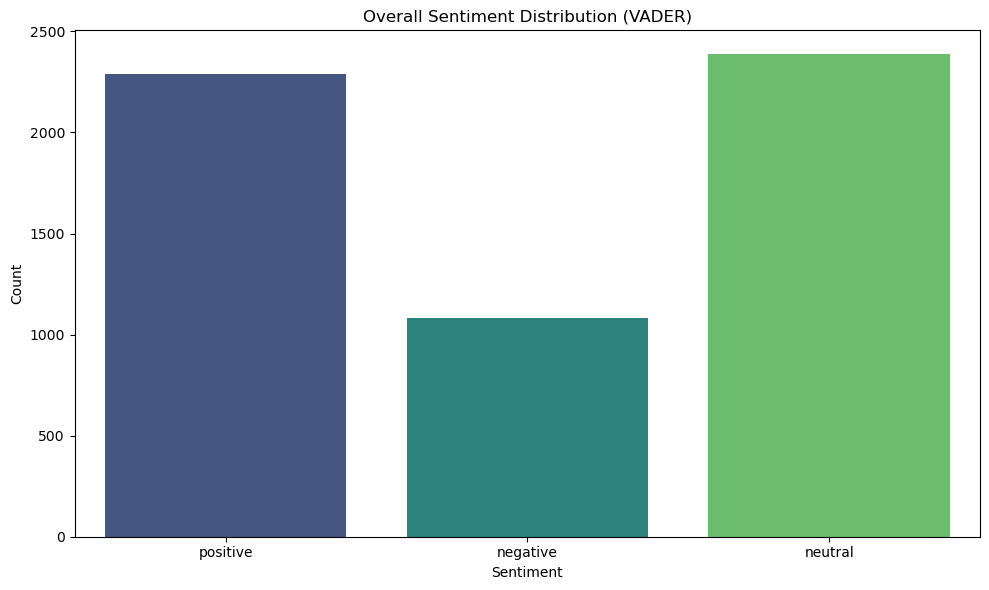

In [28]:
# Initialize VADER sentiment analyzer
vader = SentimentIntensityAnalyzer()

def analyze_vader_sentiment(text):
    """Analyze sentiment using VADER"""
    if pd.isna(text) or text == "":
        return {'compound': 0, 'category': 'neutral'}

    scores = vader.polarity_scores(text)
    compound = scores['compound']

    # Categorize sentiment
    if compound >= 0.05:
        category = 'positive'
    elif compound <= -0.05:
        category = 'negative'
    else:
        category = 'neutral'

    return {'compound': compound, 'category': category}

# Apply VADER sentiment analysis
print("Running VADER sentiment analysis...")
vader_results = df['text'].apply(analyze_vader_sentiment)
df['vader_compound'] = vader_results.apply(lambda x: x['compound'])
df['vader_sentiment'] = vader_results.apply(lambda x: x['category'])

# Sentiment distribution visualization
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='vader_sentiment', palette='viridis')
plt.title('Overall Sentiment Distribution (VADER)')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.tight_layout()
plt.show()


In [29]:
# Filter for non-empty text
text_df = df[df['clean_text'].str.len() > 10].reset_index(drop=False)  # Change drop=True to drop=False

# Prepare corpus for BERTopic
docs = text_df['clean_text'].tolist()

print(f"Performing topic modeling on {len(docs):,} documents...")

# Train BERTopic model
topic_model = BERTopic(language="english", calculate_probabilities=True, verbose=True)
topics, probs = topic_model.fit_transform(docs)

# Add topics to the dataframe
text_df['topic'] = topics
text_df['topic_prob'] = probs.max(axis=1)

# Visualize the topics
fig = topic_model.visualize_topics()
fig.show()

# Get topic info
topic_info = topic_model.get_topic_info()
print("\nTop Topics:")
for i, row in topic_info.head(10).iterrows():
    if row['Topic'] != -1:  # Skip outlier topic
        print(f"Topic {row['Topic']}: {row['Name']} (size: {row['Count']})")
        words = topic_model.get_topic(row['Topic'])
        print(f"  Top words: {', '.join([word for word, _ in words[:5]])}")

# Add topics back to main dataframe
topic_mapping = dict(zip(text_df['index'], text_df['topic']))
df['topic'] = df.index.map(topic_mapping).fillna(-1).astype(int)

# Track topics over time
topics_over_time = topic_model.topics_over_time(docs,
                                                text_df['created_at'].tolist(),  # Use text_df instead of df.loc
                                                nr_bins=10)
fig = topic_model.visualize_topics_over_time(topics_over_time)
fig.show()


2025-05-10 11:04:18,567 - BERTopic - Embedding - Transforming documents to embeddings.


Performing topic modeling on 5,740 documents...


Batches:   0%|          | 0/180 [00:00<?, ?it/s]

2025-05-10 11:04:22,396 - BERTopic - Embedding - Completed ✓
2025-05-10 11:04:22,396 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-05-10 11:04:24,488 - BERTopic - Dimensionality - Completed ✓
2025-05-10 11:04:24,488 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-05-10 11:04:25,367 - BERTopic - Cluster - Completed ✓
2025-05-10 11:04:25,370 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-05-10 11:04:25,432 - BERTopic - Representation - Completed ✓



Top Topics:
Topic 0: 0_pfizerbiontech_covidvaccine_dose_pfizervaccine (size: 984)
  Top words: pfizerbiontech, covidvaccine, dose, pfizervaccine, and
Topic 1: 1_vaccine_pfizerbiontech_the_my (size: 709)
  Top words: vaccine, pfizerbiontech, the, my, dose
Topic 2: 2_eu_the_uk_is (size: 211)
  Top words: eu, the, uk, is, vaccines
Topic 3: 3_arm_sore_hours_side (size: 205)
  Top words: arm, sore, hours, side, effects
Topic 4: 4_my_to_today_covid (size: 201)
  Top words: my, to, today, covid, vaccination
Topic 5: 5_to_for_all_science (size: 139)
  Top words: to, for, all, science, this
Topic 6: 6_covid19_vaccines_are_vaccination (size: 98)
  Top words: covid19, vaccines, are, vaccination, dosing
Topic 7: 7_astrazeneca_oxfordastrazeneca_oxford_vaccine (size: 83)
  Top words: astrazeneca, oxfordastrazeneca, oxford, vaccine, vaccines
Topic 8: 8_mrna_moderna_vaccines_rna (size: 80)
  Top words: mrna, moderna, vaccines, rna, mrnavaccine


10it [00:00, 21.20it/s]


Device set to use mps:0


Loading transformer-based sentiment analyzer...
Running transformer sentiment on 2000 tweets...


<Figure size 1200x800 with 0 Axes>

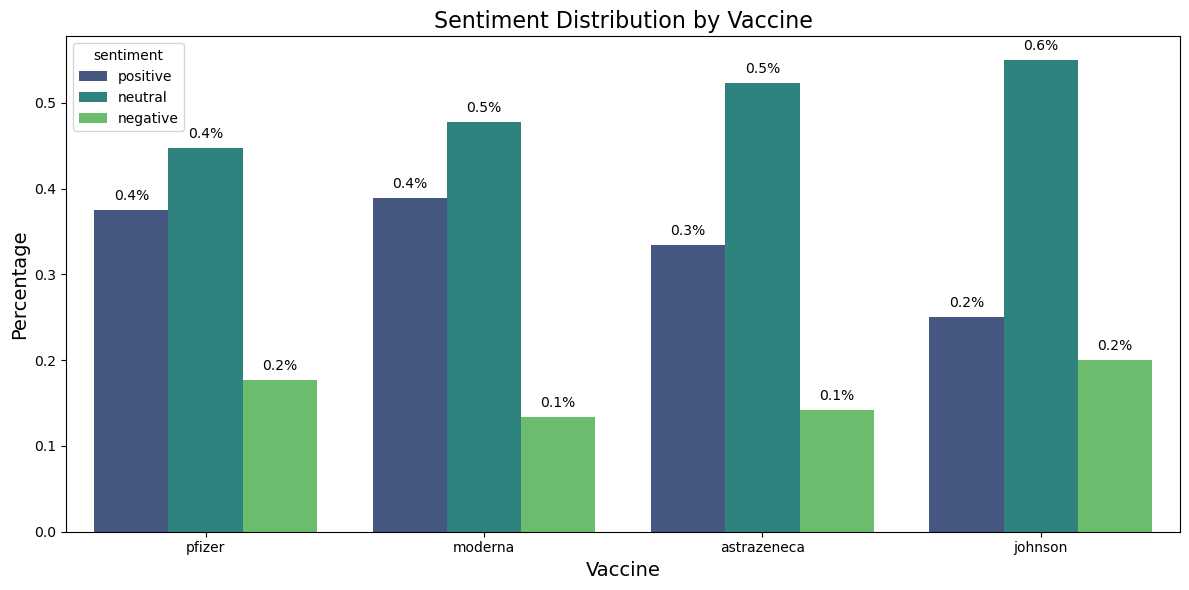

In [30]:
# Create a more advanced transformer-based sentiment analyzer
from transformers import pipeline

# Initialize the sentiment analysis pipeline
print("Loading transformer-based sentiment analyzer...")
classifier = pipeline('sentiment-analysis', model="distilbert-base-uncased-finetuned-sst-2-english")

# Function to analyze sentiment with transformer
def analyze_transformer_sentiment(texts, batch_size=32):
    results = []
    # Process in batches to avoid memory issues
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        batch_results = classifier(batch)
        results.extend(batch_results)
    return results

# Sample a subset for transformer analysis (to save time)
sample_size = min(2000, len(df))
sampled_df = df.sample(sample_size)

# Run transformer sentiment analysis on sample
print(f"Running transformer sentiment on {sample_size} tweets...")
transformer_results = analyze_transformer_sentiment(sampled_df['clean_text'].tolist())
sampled_df['transformer_label'] = [r['label'] for r in transformer_results]
sampled_df['transformer_score'] = [r['score'] for r in transformer_results]

# Compare sentiment across vaccines
plt.figure(figsize=(12, 8))
vaccine_sentiments = []

for vaccine in vaccine_keywords.keys():
    # VADER sentiment by vaccine
    vac_sentiment = df[df[f'mentions_{vaccine}']]['vader_sentiment'].value_counts(normalize=True)
    vaccine_sentiments.append({
        'vaccine': vaccine,
        'positive': vac_sentiment.get('positive', 0),
        'neutral': vac_sentiment.get('neutral', 0),
        'negative': vac_sentiment.get('negative', 0)
    })

# Create DataFrame for visualization
sent_df = pd.DataFrame(vaccine_sentiments)
sent_df = sent_df.melt(id_vars=['vaccine'], var_name='sentiment', value_name='percentage')

# Plot sentiment comparison
plt.figure(figsize=(12, 6))
chart = sns.barplot(data=sent_df, x='vaccine', y='percentage', hue='sentiment', palette='viridis')
chart.set_title('Sentiment Distribution by Vaccine', fontsize=16)
chart.set_xlabel('Vaccine', fontsize=14)
chart.set_ylabel('Percentage', fontsize=14)
chart.bar_label(chart.containers[0], fmt='%.1f%%', padding=5)
chart.bar_label(chart.containers[1], fmt='%.1f%%', padding=5)
chart.bar_label(chart.containers[2], fmt='%.1f%%', padding=5)
plt.tight_layout()
plt.show()


In [31]:
# Build retweet/mention network
def create_interaction_network(df, user_col='user_name', interaction_col='mentions', min_weight=2):
    G = nx.Graph()

    # Add nodes (users)
    users = df[user_col].unique()
    G.add_nodes_from(users)

    # Add edges for interactions
    interactions = {}
    for _, row in df.iterrows():
        user = row[user_col]
        for mentioned in row[interaction_col]:
            if mentioned and mentioned != user:  # Avoid self-loops
                key = tuple(sorted([user, mentioned]))
                interactions[key] = interactions.get(key, 0) + 1

    # Add weighted edges
    for (user1, user2), weight in interactions.items():
        if weight >= min_weight:  # Only add edges with sufficient interactions
            G.add_edge(user1, user2, weight=weight)

    return G

# Create the network
print("Building interaction network...")
mention_network = create_interaction_network(df, min_weight=1)
print(f"Network has {mention_network.number_of_nodes()} nodes and {mention_network.number_of_edges()} edges")

# Calculate centrality metrics
print("Calculating network metrics...")
# Degree centrality
degree_cent = nx.degree_centrality(mention_network)
# PageRank
pagerank = nx.pagerank(mention_network, weight='weight')
# Betweenness (on a sample if the network is large)
if mention_network.number_of_nodes() > 1000:
    print("Network is large, calculating betweenness on top nodes only...")
    top_nodes = sorted(pagerank, key=pagerank.get, reverse=True)[:500]
    sub_graph = mention_network.subgraph(top_nodes)
    betweenness = nx.betweenness_centrality(sub_graph, weight='weight')
else:
    betweenness = nx.betweenness_centrality(mention_network, weight='weight')

# Identify communities
print("Detecting communities...")
communities = community_louvain.best_partition(mention_network)
modularity = community_louvain.modularity(communities, mention_network)
print(f"Network modularity: {modularity:.4f}")

# Show top influencers
print("\nTop 10 Influencers by PageRank:")
top_influencers = sorted(pagerank.items(), key=lambda x: x[1], reverse=True)[:10]
for user, score in top_influencers:
    print(f"{user}: {score:.4f}")

# Visualize network with PyVis
def visualize_network(G, centrality_dict, communities, output_path='network.html', max_nodes=300):
    # Create subset for visualization if needed
    if G.number_of_nodes() > max_nodes:
        top_nodes = sorted(centrality_dict, key=centrality_dict.get, reverse=True)[:max_nodes]
        G = G.subgraph(top_nodes)

    # Create PyVis network
    net = Network(height="750px", width="100%", notebook=True, bgcolor="#222222", font_color="white")

    # Set node properties based on centrality and community
    community_colors = ["#e41a1c", "#377eb8", "#4daf4a", "#984ea3", "#ff7f00", "#ffff33", "#a65628", "#f781bf"]

    for node in G.nodes():
        size = 10 + 50 * centrality_dict.get(node, 0)  # Node size based on centrality
        community_id = communities.get(node, 0)
        color = community_colors[community_id % len(community_colors)]
        net.add_node(node, size=size, title=f"User: {node}\nCentrality: {centrality_dict.get(node, 0):.4f}", color=color)

    # Add edges with weights
    for source, target, data in G.edges(data=True):
        width = 1 + 0.5 * data.get('weight', 1)
        net.add_edge(source, target, width=width, title=f"Weight: {data.get('weight', 1)}")

    # Set physics layout options
    net.barnes_hut(gravity=-80000, central_gravity=0.3, spring_length=250, spring_strength=0.001, damping=0.09)
    net.save_graph(output_path)
    return net

# Visualize network
print("Generating interactive network visualization...")
net_vis = visualize_network(mention_network, pagerank, communities, 'vaccine_network.html')
net_vis.show('vaccine_network.html')


Building interaction network...
Network has 5556 nodes and 2467 edges
Calculating network metrics...
Network is large, calculating betweenness on top nodes only...
Detecting communities...
Network modularity: 0.9170

Top 10 Influencers by PageRank:
pfizer: 0.0109
Simon Hodes ⬅️2m➡️ 😷: 0.0102
Whtrslugcaviiersong#dontstayhomeandcatchcovid19: 0.0058
BorisJohnson: 0.0050
Ian 3.5% #FBPE: 0.0049
Medical Study Blog: 0.0045
🕷Financial Bear 3.5%: 0.0044
ℙ𝕙𝕚𝕝 ⚒ #FBPE #RejoinEU #GTTO: 0.0043
Rose Webster: 0.0036
WHO: 0.0035
Generating interactive network visualization...
vaccine_network.html


In [33]:
!pip install wordcloud

In [34]:
# Fixed version of create_dashboard function
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from community import community_louvain
import plotly.express as px
from wordcloud import WordCloud
import ipywidgets as widgets
from IPython.display import display
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

def create_dashboard():
    # Create tabs
    tab = widgets.Tab()
    children = []

    # Tab 1: Sentiment Trends
    tab1 = widgets.Output()
    with tab1:
        # Create sentiment over time visualization
        print("Visualizing sentiment trends...")
        df_time = df.copy()
        df_time['date'] = df_time['created_at'].dt.date
        sentiment_by_date = df_time.groupby('date')['vader_compound'].mean().reset_index()
        
        plt.figure(figsize=(12, 6))
        plt.plot(sentiment_by_date['date'], sentiment_by_date['vader_compound'], 'b-', linewidth=2)
        plt.axhline(y=0, color='r', linestyle='--', alpha=0.3)
        plt.title('Sentiment Trend Over Time')
        plt.xlabel('Date')
        plt.ylabel('Average Sentiment Score')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
        
        # Create wordcloud
        print("\nGenerating wordcloud of common terms...")
        text = " ".join(df['clean_text'].dropna())
        wordcloud = WordCloud(width=800, height=400, background_color='black', 
                             colormap='viridis', max_words=100).generate(text)
        
        plt.figure(figsize=(12, 6))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.tight_layout()
        plt.show()
    
    children.append(tab1)

    # Tab 2: Network Analysis
    tab2 = widgets.Output()
    with tab2:
        print("Displaying network visualization...")
        print("This is an interactive network that was previously generated.")
        print("The network visualization shows connections between users based on mentions and retweets.")
        print("\nNetwork Statistics:")
        print(f"Number of nodes: {mention_network.number_of_nodes()}")
        print(f"Number of edges: {mention_network.number_of_edges()}")
        
        # Display top influencers
        print("\nTop 10 Influencers (by PageRank centrality):")
        top_influencers = sorted(pagerank.items(), key=lambda x: x[1], reverse=True)[:10]
        for i, (user, score) in enumerate(top_influencers, 1):
            print(f"{i}. {user}: {score:.4f}")
            
        # Display community information
        community_sizes = {}
        for user, community_id in communities.items():
            community_sizes[community_id] = community_sizes.get(community_id, 0) + 1
            
        print("\nCommunity Sizes:")
        for community_id, size in sorted(community_sizes.items(), key=lambda x: x[1], reverse=True)[:5]:
            print(f"Community {community_id}: {size} members")
    
    children.append(tab2)

    # Tab 3: Topic Modeling
    tab3 = widgets.Output()
    with tab3:
        print("Performing topic modeling...")
        # Simple LDA topic modeling
        vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english', max_features=1000)
        dtm = vectorizer.fit_transform(df['clean_text'].dropna())
        
        lda = LatentDirichletAllocation(n_components=5, random_state=42)
        lda.fit(dtm)
        
        terms = vectorizer.get_feature_names_out()
        
        print("Top terms for each topic:")
        for i, topic in enumerate(lda.components_):
            print(f"\nTopic {i+1}:")
            print(", ".join([terms[i] for i in topic.argsort()[-10:]]))
            
        # Create simple topic distribution plot
        topic_values = lda.transform(dtm).argmax(axis=1)
        topic_counts = pd.Series(topic_values).value_counts().sort_index()
        
        plt.figure(figsize=(10, 6))
        plt.bar(range(len(topic_counts)), topic_counts.values)
        plt.xlabel('Topic Number')
        plt.ylabel('Number of Documents')
        plt.title('Document Distribution Across Topics')
        plt.xticks(range(len(topic_counts)), [f"Topic {i+1}" for i in range(len(topic_counts))])
        plt.show()
    
    children.append(tab3)

    # Tab 4: Influencer Analysis
    tab4 = widgets.Output()
    with tab4:
        print("Analyzing top influencers...")
        # Create a dataframe with centrality metrics
        user_metrics = []
        for user in pagerank:
            user_metrics.append({
                'user': user,
                'pagerank': pagerank.get(user, 0),
                'degree_centrality': degree_cent.get(user, 0),
                'betweenness': betweenness.get(user, 0),
                'community': communities.get(user, 0)
            })
        
        influencer_df = pd.DataFrame(user_metrics)
        influencer_df = influencer_df.sort_values('pagerank', ascending=False).head(20)
        
        # Create visualization
        plt.figure(figsize=(12, 8))
        plt.scatter(influencer_df['degree_centrality'], influencer_df['pagerank'], 
                   s=100, alpha=0.7, c=influencer_df['community'], cmap='viridis')
        
        for i, row in influencer_df.head(10).iterrows():
            plt.annotate(row['user'], 
                        (row['degree_centrality'], row['pagerank']),
                        fontsize=9, ha='center')
            
        plt.title('Top Influencers: PageRank vs Degree Centrality')
        plt.xlabel('Degree Centrality')
        plt.ylabel('PageRank')
        plt.colorbar(label='Community ID')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
        
        # List top influencers
        print("\nTop 20 Influencers:")
        for i, row in influencer_df.iterrows():
            print(f"{row['user']}: PageRank={row['pagerank']:.4f}, Degree={row['degree_centrality']:.4f}")
    
    children.append(tab4)

    # Tab 5: Community Sentiment
    tab5 = widgets.Output()
    with tab5:
        print("Analyzing sentiment by community...")
        # Create a dataframe mapping users to communities and sentiments
        user_community = []
        for user, community_id in communities.items():
            # Get tweets from this user
            user_tweets = df[df['user_name'] == user]
            if not user_tweets.empty:
                avg_sentiment = user_tweets['vader_compound'].mean()
                user_community.append({
                    'user': user,
                    'community': community_id,
                    'sentiment': avg_sentiment,
                    'tweet_count': len(user_tweets)
                })
        
        community_df = pd.DataFrame(user_community)
        
        # Calculate average sentiment by community
        community_sentiment = community_df.groupby('community').agg({
            'sentiment': 'mean',
            'user': 'count',
            'tweet_count': 'sum'
        }).sort_values('user', ascending=False).reset_index()
        
        community_sentiment = community_sentiment.rename(columns={'user': 'user_count'})
        community_sentiment = community_sentiment[community_sentiment['user_count'] > 5]  # Filter small communities
        
        # Create visualization
        plt.figure(figsize=(12, 6))
        bars = plt.bar(community_sentiment['community'], community_sentiment['sentiment'], 
               alpha=0.7, color=plt.cm.viridis(community_sentiment['sentiment']/2 + 0.5))
        
        plt.axhline(y=0, color='r', linestyle='--', alpha=0.3)
        plt.title('Average Sentiment by Community')
        plt.xlabel('Community ID')
        plt.ylabel('Average Sentiment')
        plt.xticks(rotation=45)
        
        # Add user count as text
        for i, bar in enumerate(bars):
            plt.text(bar.get_x() + bar.get_width()/2, 
                    bar.get_height() + 0.02 if bar.get_height() >= 0 else bar.get_height() - 0.05,
                    f"n={community_sentiment.iloc[i]['user_count']}", 
                    ha='center', va='bottom', fontsize=8)
        
        plt.tight_layout()
        plt.show()
        
        # Print community sentiment stats
        print("\nCommunity Sentiment Analysis:")
        print(community_sentiment.sort_values('sentiment', ascending=False).head(10))
    
    children.append(tab5)

    # Tab 6: Information Propagation
    tab6 = widgets.Output()
    with tab6:
        print("Analyzing information propagation...")
        # Build and analyze cascades
        print("Building cascades network...")
        G_cascades = build_cascades(df)
        cascade_df = analyze_cascades(G_cascades)
        metrics = propagation_metrics(cascade_df)
        
        # Display metrics
        print("\nInformation Propagation Metrics:")
        print(f"Average Cascade Size: {metrics['average_cascade_size']:.2f} users")
        print(f"Average Cascade Duration: {metrics['average_cascade_duration']}")
        print(f"Number of Cascades: {len(cascade_df)}")
        
        # Create simple visualization
        plt.figure(figsize=(10, 6))
        # Convert timedelta to hours for better plotting
        cascade_df['duration_hours'] = cascade_df['duration'].apply(lambda x: x.total_seconds() / 3600)
        
        plt.scatter(cascade_df['duration_hours'], cascade_df['size'], alpha=0.5)
        plt.xscale('log')
        plt.yscale('log')
        plt.title('Information Cascades: Size vs Duration')
        plt.xlabel('Cascade Duration (hours, log scale)')
        plt.ylabel('Cascade Size (users, log scale)')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
        
        # Print largest cascades
        print("\nLargest Cascades:")
        largest_cascades = cascade_df.sort_values('size', ascending=False).head(5)
        for i, row in largest_cascades.iterrows():
            print(f"Cascade {i+1}: {row['size']} users, {row['duration']} duration")
    
    children.append(tab6)

    # Tab 7: Causal Inference
    tab7 = widgets.Output()
    with tab7:
        print("Performing causal inference analysis...")
        # Define important event dates (key vaccine events)
        events = {
            'Moderna EUA': '2020-12-18',
            'Pfizer EUA': '2020-12-11',
            'J&J EUA': '2021-02-27',
        }
        
        # Create simple sentiment comparison visualization
        event_date = events['Moderna EUA']
        print(f"\nAnalyzing effects of {event_date} (Moderna EUA)")
        
        # Add vader_compound as sentiment_score if it doesn't exist
        df_did = df.copy()
        if 'sentiment_score' not in df_did.columns:
            df_did['sentiment_score'] = df_did['vader_compound']
        
        event_date_pd = pd.to_datetime(event_date)
        df_did['days_from_event'] = (df_did['created_at'] - event_date_pd).dt.days
        
        # Create visualization
        df_window = df_did[(df_did['days_from_event'] >= -30) & (df_did['days_from_event'] <= 30)]
        daily_sentiment = df_window.groupby('days_from_event')['sentiment_score'].mean().reset_index()
        
        plt.figure(figsize=(12, 6))
        plt.plot(daily_sentiment['days_from_event'], daily_sentiment['sentiment_score'], 'b-', linewidth=2)
        plt.axvline(x=0, color='r', linestyle='--', alpha=0.7, label='Event Date')
        plt.axhline(y=0, color='gray', linestyle='--', alpha=0.3)
        
        # Calculate pre and post averages
        pre_event = daily_sentiment[daily_sentiment['days_from_event'] < 0]['sentiment_score'].mean()
        post_event = daily_sentiment[daily_sentiment['days_from_event'] >= 0]['sentiment_score'].mean()
        
        plt.axhline(y=pre_event, color='blue', linestyle=':', alpha=0.5, label=f'Pre-Event Avg: {pre_event:.3f}')
        plt.axhline(y=post_event, color='green', linestyle=':', alpha=0.5, label=f'Post-Event Avg: {post_event:.3f}')
        
        plt.title(f'Sentiment Before and After Event (Moderna EUA - {event_date})')
        plt.xlabel('Days from Event (0 = Event Date)')
        plt.ylabel('Average Sentiment Score')
        plt.grid(True, alpha=0.2)
        plt.legend()
        plt.tight_layout()
        plt.show()
        
        # Simple statistical test
        pre_event_data = df_did[df_did['created_at'] < event_date_pd]['sentiment_score']
        post_event_data = df_did[df_did['created_at'] >= event_date_pd]['sentiment_score']
        
        print("\nSimple Before-After Analysis:")
        print(f"Pre-event mean sentiment: {pre_event_data.mean():.4f} (n={len(pre_event_data)})")
        print(f"Post-event mean sentiment: {post_event_data.mean():.4f} (n={len(post_event_data)})")
        print(f"Change: {post_event_data.mean() - pre_event_data.mean():.4f}")
        
        # Try to do a simple DiD if we have a treatment variable
        if 'mentions_moderna' in df.columns:
            print("\nDifference-in-Differences Analysis:")
            print("Using mentions of 'moderna' as treatment group...")
            
            # Prepare DiD data
            df_did['post_event'] = (df_did['created_at'] >= event_date_pd).astype(int)
            df_did['treatment'] = df_did['mentions_moderna'].astype(int)
            df_did['interaction'] = df_did['treatment'] * df_did['post_event']
            
            # Calculate group means
            groups = df_did.groupby(['treatment', 'post_event'])['sentiment_score'].mean().reset_index()
            
            print("\nGroup Means:")
            for _, row in groups.iterrows():
                group_type = f"{'Treatment' if row['treatment'] else 'Control'}, {'Post' if row['post_event'] else 'Pre'}"
                print(f"{group_type}: {row['sentiment_score']:.4f}")
            
            # Calculate DiD manually
            control_pre = groups[(groups['treatment'] == 0) & (groups['post_event'] == 0)]['sentiment_score'].values[0]
            control_post = groups[(groups['treatment'] == 0) & (groups['post_event'] == 1)]['sentiment_score'].values[0]
            treat_pre = groups[(groups['treatment'] == 1) & (groups['post_event'] == 0)]['sentiment_score'].values[0]
            treat_post = groups[(groups['treatment'] == 1) & (groups['post_event'] == 1)]['sentiment_score'].values[0]
            
            did_effect = (treat_post - treat_pre) - (control_post - control_pre)
            print(f"\nDiD Estimate: {did_effect:.4f}")
            print(f"Interpretation: The causal effect of Moderna EUA approval on sentiment was {did_effect:.4f} points")
        else:
            # Use follower count as treatment
            print("\nUsing follower count as treatment variable...")
            
            # Prepare DiD data
            if 'user_followers' in df.columns:
                df_did['post_event'] = (df_did['created_at'] >= event_date_pd).astype(int)
                follower_median = df['user_followers'].median()
                df_did['treatment'] = (df_did['user_followers'] > follower_median).astype(int)
                df_did['interaction'] = df_did['treatment'] * df_did['post_event']
                
                # Calculate group means
                groups = df_did.groupby(['treatment', 'post_event'])['sentiment_score'].mean().reset_index()
                
                print("\nGroup Means:")
                for _, row in groups.iterrows():
                    group_type = f"{'High followers' if row['treatment'] else 'Low followers'}, {'Post' if row['post_event'] else 'Pre'}"
                    print(f"{group_type}: {row['sentiment_score']:.4f}")
                
                # Calculate DiD manually
                try:
                    control_pre = groups[(groups['treatment'] == 0) & (groups['post_event'] == 0)]['sentiment_score'].values[0]
                    control_post = groups[(groups['treatment'] == 0) & (groups['post_event'] == 1)]['sentiment_score'].values[0]
                    treat_pre = groups[(groups['treatment'] == 1) & (groups['post_event'] == 0)]['sentiment_score'].values[0]
                    treat_post = groups[(groups['treatment'] == 1) & (groups['post_event'] == 1)]['sentiment_score'].values[0]
                    
                    did_effect = (treat_post - treat_pre) - (control_post - control_pre)
                    print(f"\nDiD Estimate: {did_effect:.4f}")
                    print(f"Interpretation: The differential effect on high-follower accounts was {did_effect:.4f} points")
                except:
                    print("Unable to calculate DiD - missing data for one or more groups")
            else:
                print("Cannot perform DiD analysis: Missing treatment variable (user_followers)")
    
    children.append(tab7)

    # Set the children 
    tab.children = children
    
    # Set tab titles
    tab_titles = ['Sentiment Trends', 'Network Analysis', 'Topic Modeling',
                'Influencer Analysis', 'Community Sentiment',
                'Information Propagation', 'Causal Inference']
    
    # Set tab titles
    for i, title in enumerate(tab_titles):
        tab.set_title(i, title)
    
    return tab

# Create and display the dashboard
dashboard = create_dashboard()
display(dashboard)